In [1]:
# import packages and libaraies
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import pickle
from glob import glob
import itertools
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import *
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import csv
from csv import reader
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
# mount zip file from google drive, extract zip files
drive.mount('/content/gdrive')
!unzip /content/gdrive/MyDrive/archive.zip

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/archive.zip
  inflating: Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv  
  inflating: Fitabase Data 4.12.16-5.12.16/dailyCalories_merged.csv  
  inflating: Fitabase Data 4.12.16-5.12.16/dailyIntensities_merged.csv  
  inflating: Fitabase Data 4.12.16-5.12.16/dailySteps_merged.csv  
  inflating: Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv  
  inflating: Fitabase Data 4.12.16-5.12.16/hourlyCalories_merged.csv  
  inflating: Fitabase Data 4.12.16-5.12.16/hourlyIntensities_merged.csv  
  inflating: Fitabase Data 4.12.16-5.12.16/hourlySteps_merged.csv  
  inflating: Fitabase Data 4.12.16-5.12.16/minuteCaloriesNarrow_merged.csv  
  inflating: Fitabase Data 4.12.16-5.12.16/minuteCaloriesWide_merged.csv  
  inflating: Fitabase Data 4.12.16-5.12.16/minuteIntensitiesNarrow_merged.csv  
  inflating: Fitabase Data 4.12.16-5.12.16/minuteIntensitiesWide_merged.csv  
  inflating: Fitabase Data 4.12.16-5.12.16/minuteM

In [3]:
# Import all csv files into dfs

# d_activity includes the below three tables
d_activity = pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv')
#d_calories = pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/dailyCalories_merged.csv')
#d_intensities = pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/dailyIntensities_merged.csv')
#d_steps = pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/dailySteps_merged.csv')

heartrate = pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv')
h_calories= pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/hourlyCalories_merged.csv')
h_intensities= pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/hourlyIntensities_merged.csv')
h_steps= pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/hourlySteps_merged.csv')
m_calories_n = pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/minuteCaloriesNarrow_merged.csv')
m_calories_w = pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/minuteCaloriesWide_merged.csv')
m_intensities_n= pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/minuteIntensitiesNarrow_merged.csv')
m_intensities_w= pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/minuteIntensitiesWide_merged.csv')
m_mey_n = pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/minuteMETsNarrow_merged.csv')
m_sleep = pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/minuteSleep_merged.csv')
m_sleep_n = pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/minuteStepsNarrow_merged.csv')
m_sleep_w = pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/minuteStepsWide_merged.csv')
sleepday = pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv')
weight = pd.read_csv('/content/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv')

# Daily Activity Breakdown
1. There are total of 33 users included in the daily activity dataset
2. Majority of the users have 30 inputs / timestamps, and the frequency distribution is highly left skewed
3. General statistics for activitiy (for all users across all timestamps)
- The average of total steps is 7637.9 steps
- The average of total distance is 5.48 miles 
- The average of calories is 2303
- The distributions are shown in the histograms below
4. The intensity of the daily activity (for all users across all timestamps)
- The average of very active distance is 1.50, and very active minute is 21.16
- The average of moderately active distance is 0.57, and fairly active minute is 13.56
- The average of very light distance is 3.34, and lightly active minute is 192.81
- The average of sedentary active distance is 0.0016, and sedentary active minute is 991.21
- There is a positive correlation between activitiy distance and time except for sedentary activity
- The distributions are shown in the histograms below, as well as the scatterplot between distance and minutes, and pie charts for overall average distance and minutes


In [4]:
# 1. total number of users
total_num_user = len(d_activity['Id'].value_counts())
print('Total of '+str(total_num_user)+' users are included in the dataset')

Total of 33 users are included in the dataset


Text(0, 0.5, 'Frequency')

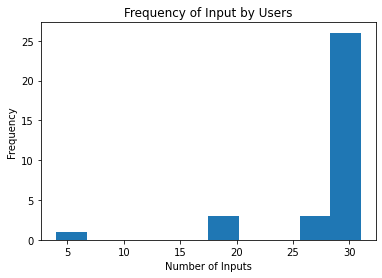

In [5]:
# 2. Frequency Distribution
plt.hist(list(d_activity['Id'].value_counts()))
plt.title('Frequency of Input by Users')
plt.xlabel('Number of Inputs')
plt.ylabel('Frequency')

Average total steps is 7637.9106382978725
Average total distance is 5.489702121915415
Average total calories is 2303.609574468085


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Calories')]

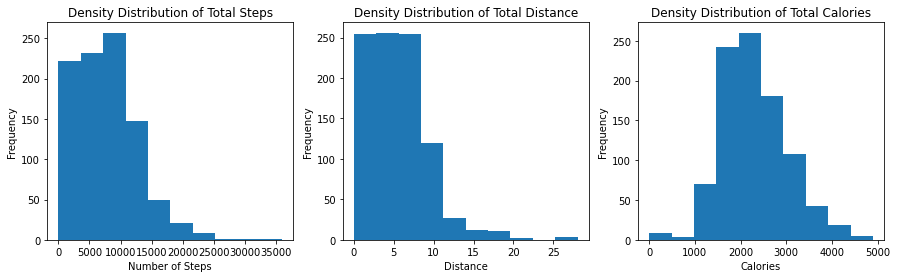

In [6]:
# 3. General statistics for activitiy
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))

avgs_s = d_activity['TotalSteps'].mean()
print('Average total steps is '+str(avgs_s))
axs[0].hist(list(d_activity['TotalSteps']))
axs[0].set_title('Density Distribution of Total Steps')
axs[0].set(xlabel='Number of Steps', ylabel='Frequency')

avgs_d = d_activity['TotalDistance'].mean()
print('Average total distance is '+str(avgs_d))
axs[1].hist(list(d_activity['TotalDistance']))
axs[1].set_title('Density Distribution of Total Distance')
axs[1].set(xlabel='Distance', ylabel='Frequency')

avgs_c = d_activity['Calories'].mean()
print('Average total calories is '+str(avgs_c))
axs[2].hist(list(d_activity['Calories']))
axs[2].set_title('Density Distribution of Total Calories')
axs[2].set(xlabel='Calories', ylabel='Frequency')


Average of very active distance is 1.502680850999945
Average of very active minute is 21.164893617021278


[Text(0, 0.5, 'Distance'), Text(0.5, 0, 'Minutes')]

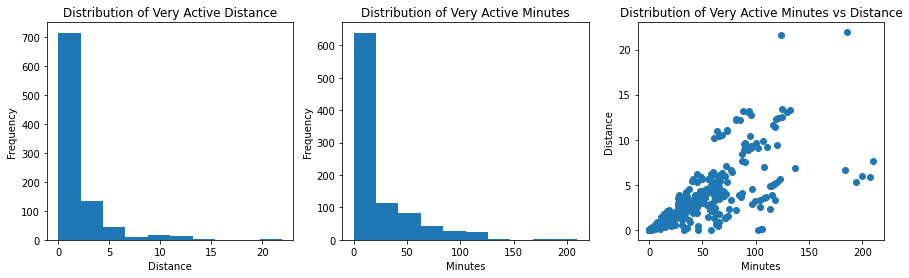

In [7]:
# 4a. Very Active Activity
very_distance = d_activity['VeryActiveDistance'].mean()
print('Average of very active distance is '+str(very_distance))

fig, axs = plt.subplots(ncols=3, figsize=(15, 4))

axs[0].hist(list(d_activity['VeryActiveDistance']))
axs[0].set_title('Distribution of Very Active Distance')
axs[0].set(xlabel='Distance', ylabel='Frequency')

very_minute = d_activity['VeryActiveMinutes'].mean()
print('Average of very active minute is '+str(very_minute))
axs[1].hist(list(d_activity['VeryActiveMinutes']))
axs[1].set_title('Distribution of Very Active Minutes')
axs[1].set(xlabel='Minutes', ylabel='Frequency')

axs[2].scatter(list(d_activity['VeryActiveMinutes']), list(d_activity['VeryActiveDistance']))
axs[2].set_title('Distribution of Very Active Minutes vs Distance')
axs[2].set(xlabel='Minutes', ylabel='Distance')

Average of moderately active distance is 0.5675425513706943
Average of fairly active minute is 13.564893617021276


[Text(0, 0.5, 'Distance'), Text(0.5, 0, 'Minutes')]

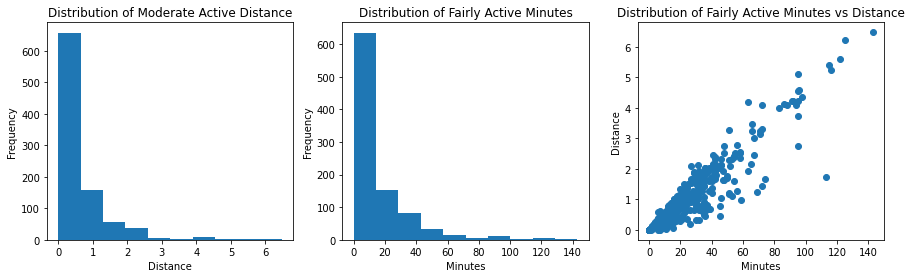

In [8]:
# 4b. Moderately Active Activity
moderate_distance = d_activity['ModeratelyActiveDistance'].mean()
print('Average of moderately active distance is '+str(moderate_distance))

fig, axs = plt.subplots(ncols=3, figsize=(15, 4))

axs[0].hist(list(d_activity['ModeratelyActiveDistance']))
axs[0].set_title('Distribution of Moderate Active Distance')
axs[0].set(xlabel='Distance', ylabel='Frequency')

moderate_minute = d_activity['FairlyActiveMinutes'].mean()
print('Average of fairly active minute is '+str(moderate_minute))
axs[1].hist(list(d_activity['FairlyActiveMinutes']))
axs[1].set_title('Distribution of Fairly Active Minutes')
axs[1].set(xlabel='Minutes', ylabel='Frequency')

axs[2].scatter(list(d_activity['FairlyActiveMinutes']), list(d_activity['ModeratelyActiveDistance']))
axs[2].set_title('Distribution of Fairly Active Minutes vs Distance')
axs[2].set(xlabel='Minutes', ylabel='Distance')

Average of very light distance is 3.3408191485885292
Average of lightly active minute is 192.8127659574468


[Text(0, 0.5, 'Distance'), Text(0.5, 0, 'Minutes')]

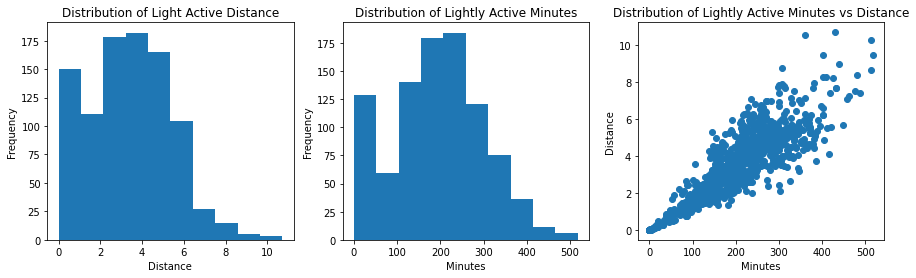

In [9]:
# 4c. Light Active Activity
light_distance = d_activity['LightActiveDistance'].mean()
print('Average of very light distance is '+str(light_distance))

fig, axs = plt.subplots(ncols=3, figsize=(15, 4))

axs[0].hist(list(d_activity['LightActiveDistance']))
axs[0].set_title('Distribution of Light Active Distance')
axs[0].set(xlabel='Distance', ylabel='Frequency')

lightly_minute = d_activity['LightlyActiveMinutes'].mean()
print('Average of lightly active minute is '+str(lightly_minute))
axs[1].hist(list(d_activity['LightlyActiveMinutes']))
axs[1].set_title('Distribution of Lightly Active Minutes')
axs[1].set(xlabel='Minutes', ylabel='Frequency')

axs[2].scatter(list(d_activity['LightlyActiveMinutes']), list(d_activity['LightActiveDistance']))
axs[2].set_title('Distribution of Lightly Active Minutes vs Distance')
axs[2].set(xlabel='Minutes', ylabel='Distance')

Average of sedentary active distance is 0.0016063829566887052
Average of sedentary active minute is 991.2106382978724


[Text(0, 0.5, 'Distance'), Text(0.5, 0, 'Minutes')]

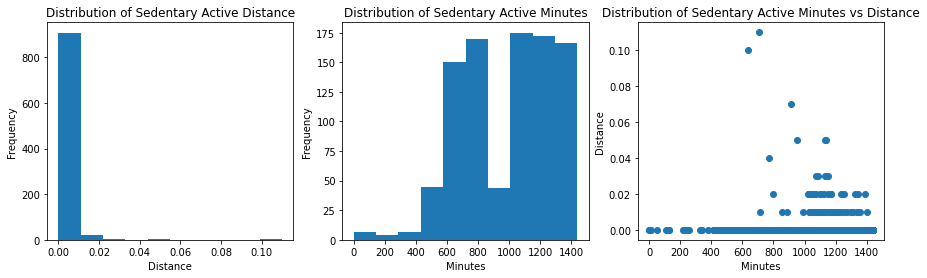

In [10]:
# 4d. Sedentary Active Activity
sedentary_distance = d_activity['SedentaryActiveDistance'].mean()
print('Average of sedentary active distance is '+str(sedentary_distance))

fig, axs = plt.subplots(ncols=3, figsize=(15, 4))

axs[0].hist(list(d_activity['SedentaryActiveDistance']))
axs[0].set_title('Distribution of Sedentary Active Distance')
axs[0].set(xlabel='Distance', ylabel='Frequency')

sedentary_minute = d_activity['SedentaryMinutes'].mean()
print('Average of sedentary active minute is '+str(sedentary_minute))
axs[1].hist(list(d_activity['SedentaryMinutes']))
axs[1].set_title('Distribution of Sedentary Active Minutes')
axs[1].set(xlabel='Minutes', ylabel='Frequency')

axs[2].scatter(list(d_activity['SedentaryMinutes']), list(d_activity['SedentaryActiveDistance']))
axs[2].set_title('Distribution of Sedentary Active Minutes vs Distance')
axs[2].set(xlabel='Minutes', ylabel='Distance')

Text(0.5, 1.0, 'Decomposition of Overall Average Activity Minute')

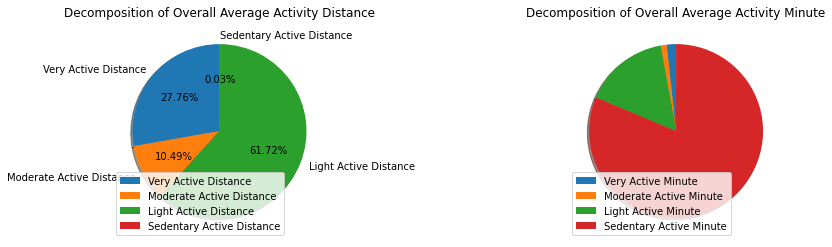

In [11]:
# 4e. Overall Average Activity Chart

distances = np.array([very_distance, moderate_distance, light_distance, sedentary_distance])
d_labels = ['Very Active Distance', 'Moderate Active Distance', 'Light Active Distance', 'Sedentary Active Distance']
minutes = np.array([very_minute, moderate_minute, lightly_minute, sedentary_minute])
m_labels = ['Very Active Minute', 'Moderate Active Minute', 'Light Active Minute', 'Sedentary Active Minute']

fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
axs[0].pie(distances,labels=d_labels, startangle=90, shadow=True, autopct='%1.2f%%')
axs[0].legend()
axs[0].set_title('Decomposition of Overall Average Activity Distance')

axs[1].pie(minutes,startangle=90,shadow=True)
axs[1].legend(m_labels)
axs[1].set_title('Decomposition of Overall Average Activity Minute')

# Basic Users' Health Information
1. METs: 
- MET refers to metabolic equivalent and 1 MET is the rate of energy expenditure while sitting at rest.
- The average MET is 14.69
- 81.07% of the users have METs between 10 - 12
2. Heart Rate
- There are total number of 15 users in the dataset
- For every user, the heart rate is measured once every 5 seconds
- The dataset contains 2483658 heart rate entries
- The average heart rate is 77.32 beats per second
3. Weight and BMI
- There are total number of 8 users in the dataset
- The average weight is 158.81 pound
- The average BMI is 25.19
- The distribution of average users' weights and BMI are quite similar, and right skewed


Average of METs is  14.690011164924034
81.08% of users have METs value within [10, 11, 12]


Text(0, 0.5, 'Number of Users')

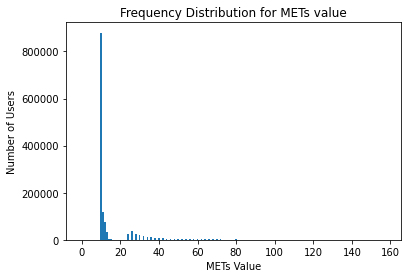

In [12]:
# 1.  METs
mets = m_mey_n['METs'].value_counts()
print('Average of METs is ', str(m_mey_n['METs'].mean()))
top3 = mets[:3].index
top3_percentage = sum(mets[:3]) * 100/sum(mets)
print(str(round(top3_percentage,2))+'% of users have METs value within '+str(list(top3)))
plt.bar(list(mets.index), list(mets))
plt.title('Frequency Distribution for METs value')
plt.xlabel('METs Value')
plt.ylabel('Number of Users')

The average heart rate is 77.33 beats per second
Total number of 14 users are included in the dataset


Text(0, 0.5, 'Frequency')

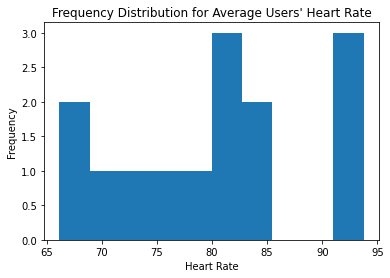

In [13]:
# 2. Heart Rate
print('The average heart rate is '+str(round(heartrate['Value'].mean(),2))+" beats per second")
avg_user = heartrate.groupby('Id')['Value'].mean()
print('Total number of '+str(avg_user.shape[0])+' users are included in the dataset')

plt.hist(list(avg_user))
plt.title("Frequency Distribution for Average Users' Heart Rate")
plt.xlabel('Heart Rate')
plt.ylabel('Frequency')

The average weight is 158.81 pound
Total number of 8 users are included in the dataset
The average BMI is 25.19


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'BMI')]

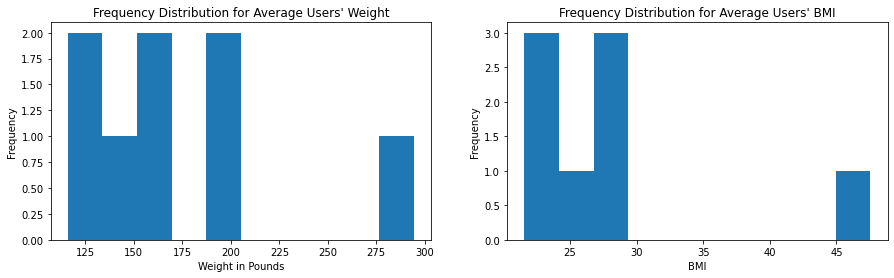

In [14]:
# 3. Weight and BMI
print('The average weight is '+str(round(weight['WeightPounds'].mean(),2))+" pound")
avg_user = weight.groupby('Id')['WeightPounds'].mean()
print('Total number of '+str(avg_user.shape[0])+' users are included in the dataset')

fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

axs[0].hist(list(avg_user))
axs[0].set_title("Frequency Distribution for Average Users' Weight")
axs[0].set(xlabel='Weight in Pounds', ylabel='Frequency')

print('The average BMI is '+str(round(weight['BMI'].mean(),2)))
avg_bmi = weight.groupby('Id')['BMI'].mean()
axs[1].hist(list(avg_bmi))
axs[1].set_title("Frequency Distribution for Average Users' BMI")
axs[1].set(xlabel='BMI', ylabel='Frequency')



# Users' Sleep Information
- Total number of 24 users are included in the dataset
1. Total Minutes Asleep
- The average total minutes asleep is 419.47 minutes
2. Total Minutes In Bed
- The average total minutes in bed is 458.64 minutes
- 87.5% of People takes less than 50 mintues to fall asleep
- The distribution for minutes asleep and minutes in bed is relatively similar
3. Sleep Value
- Sleep Value is updated every minutes
- The average number of sleep values per user is 7855.04
- The average sleep values per user is 1.11

Total number of 24 users are included in the dataset
The average total minutes asleep is 419.47 minutes
The average total minutes in bed is 458.64 minutes
87.5% of the people falls asleep within 50 mintues


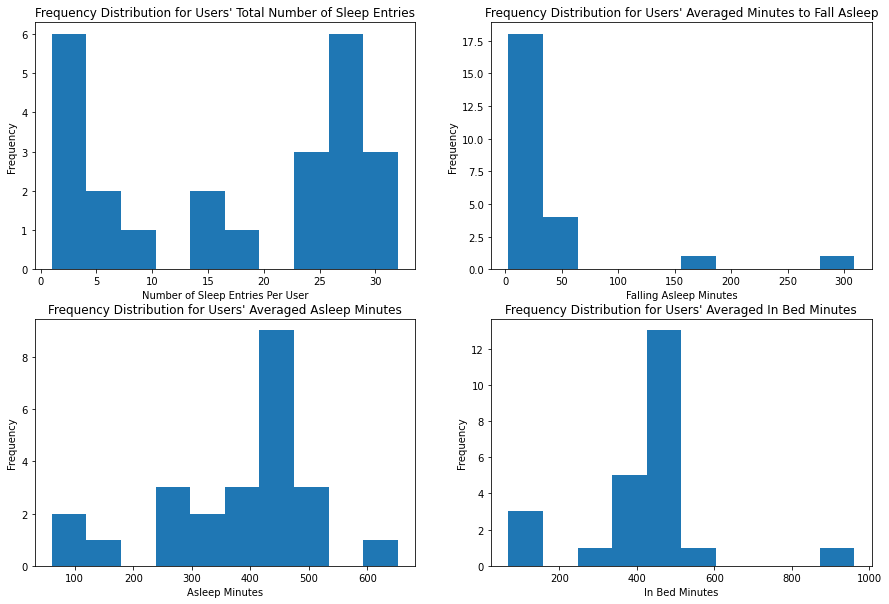

In [15]:
avg_user = sleepday.groupby('Id')['SleepDay'].count()
print('Total number of '+str(avg_user.shape[0])+' users are included in the dataset')

print('The average total minutes asleep is '+str(round(sleepday['TotalMinutesAsleep'].mean(),2))+" minutes")
print('The average total minutes in bed is '+str(round(sleepday['TotalTimeInBed'].mean(),2))+" minutes")

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

axs[0,0].hist(list(avg_user))
axs[0,0].set_title("Frequency Distribution for Users' Total Number of Sleep Entries")
axs[0,0].set(xlabel='Number of Sleep Entries Per User', ylabel='Frequency')

avg_asleep = sleepday.groupby('Id')['TotalMinutesAsleep'].mean()
avg_inbed = sleepday.groupby('Id')['TotalTimeInBed'].mean()

axs[1,0].hist(list(avg_asleep))
axs[1,0].set_title("Frequency Distribution for Users' Averaged Asleep Minutes")
axs[1,0].set(xlabel='Asleep Minutes', ylabel='Frequency')

axs[1,1].hist(list(avg_inbed))
axs[1,1].set_title("Frequency Distribution for Users' Averaged In Bed Minutes")
axs[1,1].set(xlabel='In Bed Minutes', ylabel='Frequency')

avg_awake = avg_inbed - avg_asleep
axs[0,1].hist(list(avg_awake))
axs[0,1].set_title("Frequency Distribution for Users' Averaged Minutes to Fall Asleep")
axs[0,1].set(xlabel='Falling Asleep Minutes', ylabel='Frequency')

quick_sleeper = avg_awake < 50
print(str(quick_sleeper.mean()*100)+'% of the people falls asleep within 50 mintues')


Total number of 24 users are included in the dataset
The average number/entries of sleep values per user is 7855.04
The average sleep values per user is 1.11


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Averaged Sleep Values')]

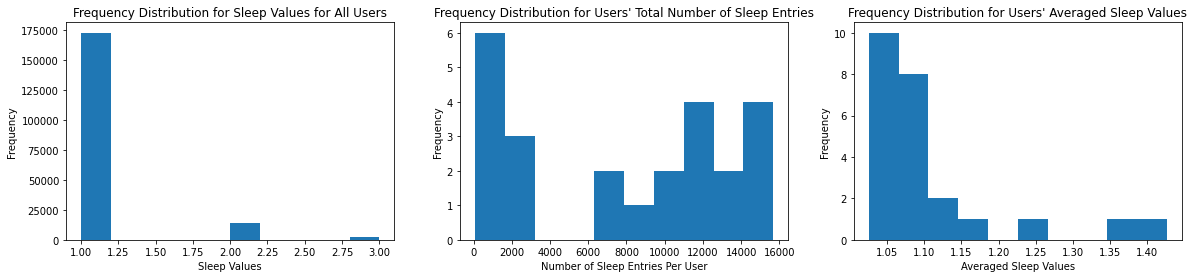

In [19]:
# 3. Sleep Value

len(m_sleep['Id'].unique())
num_user = m_sleep.groupby('Id')['date'].count()
print('Total number of '+str(avg_user.shape[0])+' users are included in the dataset')
print('The average number/entries of sleep values per user is '+str(round(num_user.mean(),2)))

avg_user = m_sleep.groupby('Id')['value'].mean()
print('The average sleep values per user is '+str(round(avg_user.mean(),2)))

fig, axs = plt.subplots(ncols=3, figsize=(20, 4))

axs[0].hist(list(m_sleep['value']))
axs[0].set_title("Frequency Distribution for Sleep Values for All Users")
axs[0].set(xlabel='Sleep Values', ylabel='Frequency')

axs[1].hist(list(num_user))
axs[1].set_title("Frequency Distribution for Users' Total Number of Sleep Entries")
axs[1].set(xlabel='Number of Sleep Entries Per User', ylabel='Frequency')

axs[2].hist(list(avg_user))
axs[2].set_title("Frequency Distribution for Users' Averaged Sleep Values")
axs[2].set(xlabel='Averaged Sleep Values', ylabel='Frequency')



In [17]:
m_sleep['value']

,Id,date,value,logId
0,1503960366,4/12/2016 2:47:30 AM,3,11380564589
1,1503960366,4/12/2016 2:48:30 AM,2,11380564589
2,1503960366,4/12/2016 2:49:30 AM,1,11380564589
3,1503960366,4/12/2016 2:50:30 AM,1,11380564589
4,1503960366,4/12/2016 2:51:30 AM,1,11380564589
...,...,...,...,...
188516,8792009665,5/4/2016 9:59:00 AM,1,11552534115
188517,8792009665,5/4/2016 10:00:00 AM,1,11552534115
188518,8792009665,5/4/2016 10:01:00 AM,1,11552534115
188519,8792009665,5/4/2016 10:02:00 AM,1,11552534115
